### Data Preprocessing

In [37]:
folders = [
    r"C:\Users\alisa\Documents\THESIS\ERPLogsAutumn_labeled", 
    r"C:\Users\alisa\Documents\THESIS\ERPLogsSummer_labeled",
    r"C:\Users\alisa\Documents\THESIS\ERPLogsWinter_labeled", 
]


In [38]:
import pandas as pd 
import re
import os

In [39]:
def parse_log(file_path):
    df = pd.read_csv(file_path)

    df['SelectionID'] = df['ObjectName'].str.extract(r'(ERPTags[AWS] ?\d+)')
    results = []


    for selection, group in df.groupby('SelectionID'):
        group = group.reset_index(drop=True)

        correct_attempts = group[group['correct'] == 1].index

        if len(correct_attempts) > 0:
            attempts_needed = correct_attempts[0] + 1
            success = True
        else: 
            attempts_needed = 4
            success = False
        
        if attempts_needed > 3:
            success = False
        
        results.append({

            'Selection':selection,
            'Attempts':attempts_needed,
            'Success':success
        })

    results_df = pd.DataFrame(results)
    return results_df

def process_log_from_folders(folder_paths):
    all_results = []
    pattern = re.compile(r"^(\w+)_([AV]{1,2})_(Aut|Sum|Win)_ERP_Selection_Log_\d{4}-\d{2}-\d{2}_\d{2}-\d{2}\.csv$")
    scene_map = {'Aut':'Autumn', 'Win':'Winter', 'Sum':'Summer'}


    for folder_path in folder_paths:
        for file in os.listdir(folder_path):
            if file.endswith('.csv'):
                file_path = os.path.join(folder_path, file)
                file_clean = os.path.basename(file_path).strip()

                match = pattern.fullmatch(file_clean)
                if match:
                    participant_id = match.group(1)
                    condition = match.group(2)
                    scene_abbr = match.group(3)
                    scene = scene_map.get(scene_abbr, 'Unknown')

                    
                    trial_df = parse_log(file_path)
                    trial_df['Participant'] = participant_id
                    trial_df['Condition'] = condition 
                    trial_df['Scene'] = scene

                    all_results.append(trial_df)
                else:
                    print(f'Filename pattern did not match: {file_clean}')
    
    if all_results:
        all_results_df = pd.concat(all_results, ignore_index=True)
        return all_results_df
    else:
        raise ValueError('No file patterns matched, check filename structure')

In [40]:
folders = [
    r"C:\Users\alisa\Documents\THESIS\ERPLogsSummer_labeled",
    r"C:\Users\alisa\Documents\THESIS\ERPLogsAutumn_labeled", 
    r"C:\Users\alisa\Documents\THESIS\ERPLogsWinter_labeled"
]


all_perf_data = process_log_from_folders(folders)

### Statistical analysis: Shapiro-Wilk normality test, paired t-test, Wilcoxon Signed-Rank test

#### Shapiro Wilk Test for normality of the differences between AV-V

In [43]:
# aggregating the data with calculated means and success rate 

from scipy.stats import ttest_rel, shapiro, wilcoxon
import numpy as np

agg = all_perf_data.groupby(['Participant', 'Condition']).agg(
    total_trials=('Success', 'count'),
    total_successes=('Success', 'sum'),
    mean_attempts=('Attempts', 'mean')
).reset_index()

agg['success_rate'] = agg['total_successes'] / agg['total_trials']

In [45]:
print(np.mean(agg['success_rate'][agg['Condition'] == 'AV']))
print(np.mean(agg['success_rate'][agg['Condition'] == 'V']))

0.981060606060606
0.9829545454545454


In [46]:
success_pivot = agg.pivot(index='Participant', columns='Condition', values='success_rate').dropna()
attempts_pivot = agg.pivot(index='Participant', columns='Condition', values='mean_attempts').dropna()

# difference scores 
success_dif = success_pivot['AV'] - success_pivot['V']
attempts_dif = attempts_pivot['AV'] - attempts_pivot['V']

# paired t-test
t_success, p_success = ttest_rel(success_pivot['AV'], success_pivot['V'])
t_attempts, p_attempts = ttest_rel(attempts_pivot['AV'], attempts_pivot['V'])

# shapiro-wilk test on normality of the differences 
shapiro_success = shapiro(success_dif)
shapiro_attempts = shapiro(attempts_dif)

# wilcoxon signed-rank test
wilcoxon_success = wilcoxon(success_dif, method='asymptotic')
wilcoxon_attempts = wilcoxon(attempts_dif)

# cohen's dz test for effect size 
dz_success = np.mean(success_dif) / np.std(success_dif, ddof=1)
dz_attempts = np.mean(attempts_dif) / np.std(attempts_dif, ddof=1)

results = pd.DataFrame({
    'Metric' : ['Success Rate', 'Mean Attempts'],
    't-value' : [t_success, t_attempts],
    'p (t-test)' : [p_success, p_attempts],
    'Shapiro p (normality)' : [shapiro_success.pvalue, shapiro_attempts.pvalue],
    'Wilcoxon p (non-parametric)' : [wilcoxon_success.pvalue, wilcoxon_attempts.pvalue],
    "Cohen's dz" : [dz_success, dz_attempts]
})

In [47]:
wilcoxon_success.zstatistic

np.float64(-0.07322520259382125)

In [48]:
results

,Metric,t-value,p (t-test),Shapiro p (normality),Wilcoxon p (non-parametric),Cohen's dz
0,Success Rate,-0.175605,0.862287,0.000068,0.941627,-0.037439
1,Mean Attempts,-0.558422,0.582462,0.925686,0.545436,-0.119056


In [49]:
# some of the interpretations are hardcoded specifically to this dataframe since we already know the results of the 
# tests. for eg for the t-value there is no condition to test what value it is, there is only one line of code for the 
# interpretation since we already know the t-value is very small 

def interpretation_table(metric_row):
    interpretations = []
    values = []
    stats = ['t-value', 'p (t-test)', 'Shapiro p (normality)', 'Wilcoxon p (non-parametric)', "Cohen's dz"]

    for stat in stats: 
        value = metric_row[stat]
        values.append(value)

        if stat == 't-value':
            interp = 'Not Significant'
        elif stat == 'p (t-test)':
            interp = 'Not significant' if value >= 0.05 else 'Significant difference'
        elif stat == 'Shapiro p (normality)':
            interp = 'Normality assumption violated' if value < 0.05 else 'Normality assumption holds'
        elif stat == 'Wilcoxon p (non-parametric)':
            interp = 'Not Significant' if value >= 0.05 else 'Significant difference'
        elif stat == "Cohen's dz":
            dz_abs = abs(value)
            if dz_abs < 0.2:
                interp = 'Negligible effect size'
            elif 0.2 <= dz_abs < 0.5:
                interp = 'Small effect size'
            elif 0.5 <= dz_abs < 0.8: 
                interp = 'Moderate effect size'
            else:
                interp = 'Large effect size'
        else: 
            interp = 'N/A'
        
        interpretations.append(interp)
    
    table = pd.DataFrame({
        'Statistic' : stats,
        'Value' : values,
        'Interpretation' : interpretations
    })

    return table

success_row = results.loc[results['Metric'] == 'Success Rate'].iloc[0]
attempts_row = results.loc[results['Metric'] == 'Mean Attempts'].iloc[0]

success_table = interpretation_table(success_row)
attempts_table = interpretation_table(attempts_row)

### Interpretation: Success rate 

- there is no statistically significant difference in success rate between AV and V (p = 0.86)
- the effect size is negligible 
- since normality of the differences is violated, a wilcoxon test was performed, which also confirms that there is no difference. 

there is no statistically significant difference between the success rate of AV and V conditions. 


In [50]:
success_table

,Statistic,Value,Interpretation
0,t-value,-0.175605,Not Significant
1,p (t-test),0.862287,Not significant
2,Shapiro p (normality),0.000068,Normality assumption violated
3,Wilcoxon p (non-parametric),0.941627,Not Significant
4,Cohen's dz,-0.037439,Negligible effect size


### Interpretation: Mean attempts 

- there is no statistically significant difference in the number of attempts between AV and V (p = 0.58)
- Normality holds for the mean attempts (shapiro p = 0.93), so the t-test is valid and confirms that there is no statistically significant difference between AV and V  

there was no significant difference between the average number of attempts of the AV and V conditions (p = 0.58).

In [51]:
attempts_table

,Statistic,Value,Interpretation
0,t-value,-0.558422,Not Significant
1,p (t-test),0.582462,Not significant
2,Shapiro p (normality),0.925686,Normality assumption holds
3,Wilcoxon p (non-parametric),0.545436,Not Significant
4,Cohen's dz,-0.119056,Negligible effect size


the addition of auditory feedback did not affect the BCI performance of the participants. 

the game itself may not have been challenging enough for the participants, considering the average success rate for AV was 98.11%, and 98.30% for V. 

In [ ]:
### descriptive stats 

# AV and V means and SDs for attempts
av_mean  = attempts_pivot['AV'].mean()
av_sd    = attempts_pivot['AV'].std(ddof=1)

v_mean   = attempts_pivot['V'].mean()
v_sd     = attempts_pivot['V'].std(ddof=1)

# already-computed paired-sample t-test
t_val,  p_val = t_attempts,  p_attempts     
df = len(attempts_pivot) - 1                
dz = dz_attempts                             


In [53]:
print('Mean Attempts descriptive stats\n')
print('AV mean' , av_mean)
print('V mean' , v_mean)
print('AV sd' , av_sd)
print('V sd' , v_sd)
print('df', df)

Mean Attempts descriptive stats

AV mean 1.2897727272727273
V mean 1.3143939393939392
AV sd 0.23091049106126574
V sd 0.24489742235219117
df 21


In [54]:
av_mean  = success_pivot['AV'].mean()
av_sd    = success_pivot['AV'].std(ddof=1)

v_mean   = success_pivot['V'].mean()
v_sd     = success_pivot['V'].std(ddof=1)


In [55]:
print('Success rate descriptive stats\n')
print('AV mean' , av_mean)
print('V mean' , v_mean)
print('AV sd' , av_sd)
print('V sd' , v_sd)


Success rate descriptive stats

AV mean 0.981060606060606
V mean 0.9829545454545454
AV sd 0.040104181307506544
V sd 0.037838181698226385


In [31]:
print('Success rate AV: ',np.mean(agg['success_rate'][agg['Condition'] == 'AV']))
print('Success rate V: ',np.mean(agg['success_rate'][agg['Condition'] == 'V']))

Success rate AV:  0.981060606060606
Success rate V:  0.9829545454545454


In [32]:
print('Mean Attempts AV: ',np.mean(agg['mean_attempts'][agg['Condition'] == 'AV']))
print('Mean Attempts V: ',np.mean(agg['mean_attempts'][agg['Condition'] == 'V']))

Mean Attempts AV:  1.2897727272727273
Mean Attempts V:  1.3143939393939392


### Box plots of the results

C:\Users\alisa\AppData\Local\Temp\ipykernel_21524\1547470594.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='success_rate', data=agg, width=0.5, showfliers=False, palette=palette)


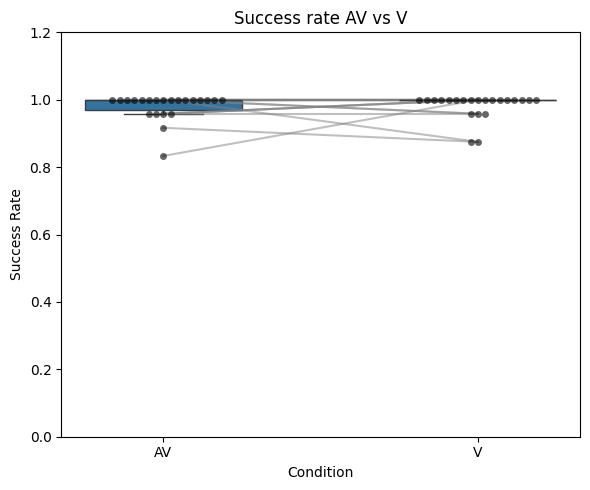

In [33]:
import matplotlib.pyplot as plt 
import seaborn as sns 

palette = {'AV': '#1f77b4', 'V': '#ff7f0e'}

plt.figure(figsize=(6,5))
sns.boxplot(x='Condition', y='success_rate', data=agg, width=0.5, showfliers=False, palette=palette)
sns.swarmplot(x='Condition', y='success_rate', data=agg, color='black', alpha=0.6)

for participant in agg['Participant'].unique():
    pair = agg[agg['Participant'] == participant].pivot(index='Participant', columns='Condition', values='success_rate')
    plt.plot(['V', 'AV'], [pair['V'].values[0], pair['AV'].values[0]], color='gray', alpha=0.5)

plt.title('Success rate AV vs V')
plt.ylim(0,1.2)
plt.ylabel('Success Rate')
plt.xlabel('Condition')
plt.tight_layout()
plt.show()




C:\Users\alisa\AppData\Local\Temp\ipykernel_21524\2340037518.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='mean_attempts', data=agg, width=0.5, showfliers=False, palette=palette)


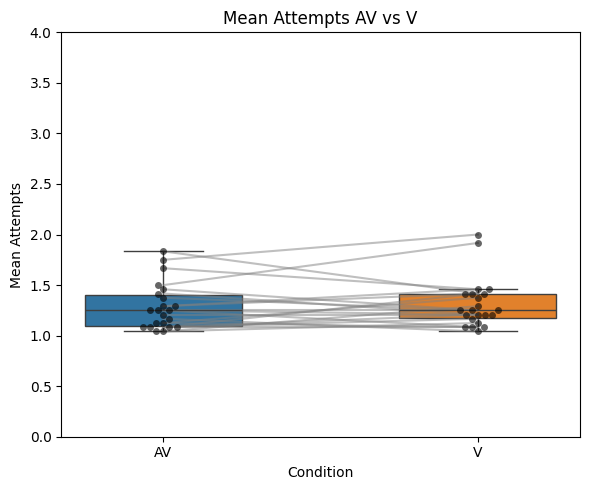

In [34]:
plt.figure(figsize=(6,5))
sns.boxplot(x='Condition', y='mean_attempts', data=agg, width=0.5, showfliers=False, palette=palette)
sns.swarmplot(x='Condition', y='mean_attempts', data=agg, color='black', alpha=0.6)

for participant in agg['Participant'].unique():
    pair = agg[agg['Participant'] == participant].pivot(index='Participant', columns='Condition', values='mean_attempts')
    plt.plot(['V', 'AV'], [pair['V'].values[0], pair['AV'].values[0]], color='gray', alpha=0.5)

plt.title('Mean Attempts AV vs V')
plt.ylim(0,4)
plt.ylabel('Mean Attempts')
plt.xlabel('Condition')
plt.tight_layout()
plt.show()


## Secondary analysis 
- attempts distribution analysis 
    - what percentage of selections were made on the first, second, third or fourth attempt
    - compare AV and V attempt distributions 

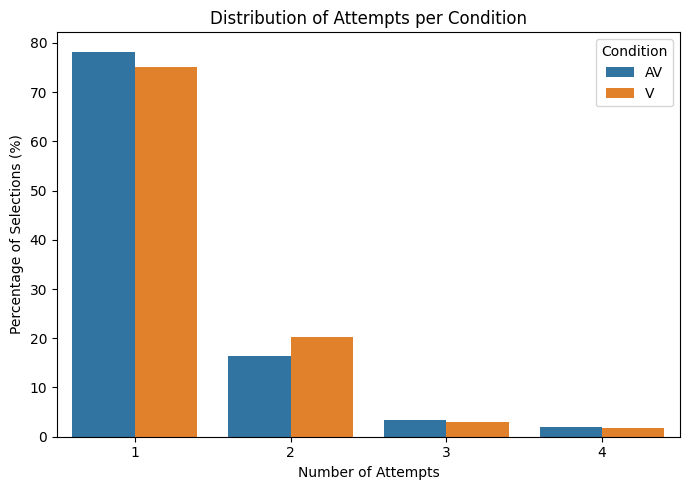

In [35]:
attempt_dist = all_perf_data.groupby(['Condition', 'Attempts']).size().reset_index(name='Count')

total_per_conditon = attempt_dist.groupby('Condition')['Count'].transform('sum')
attempt_dist['Percentage'] = attempt_dist['Count'] / total_per_conditon * 100 

plt.figure(figsize=(7,5))
sns.barplot(data=attempt_dist, x='Attempts', y='Percentage', hue='Condition', palette=palette)
plt.title("Distribution of Attempts per Condition")
plt.ylabel("Percentage of Selections (%)")
plt.xlabel("Number of Attempts")
plt.xticks([0, 1, 2, 3], [1, 2, 3, 4])  
plt.legend(title="Condition")
plt.tight_layout()
plt.show()

The majority of selections for both AV and V were made on the first attempt, which may be a further indicator of the lack of challenge in the game. 

we will conduct a Chi-Squared test of independence to further investigate the following: 
- whether the distribution of attempts differ between AV and V 
- test whether count frequencies are associated with condition 

In [36]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(all_perf_data['Condition'], all_perf_data['Attempts'])

print(contingency)

Attempts     1    2   3   4
Condition                  
AV         413   87  18  10
V          396  107  16   9


In [37]:
chi2, p, dof, expected = chi2_contingency(contingency)

print('\nChi-Square test results:')
print(f'Chi-statistic: {chi2:.4f}')
print(f'p-value: {p:.4f}')
print(f'Degrees of Freedom: {dof}')


Chi-Square test results:
Chi-statistic: 2.5894
p-value: 0.4594
Degrees of Freedom: 3


p > 0.05, hence the distributions of attempts do not significantly differ between the AV and V conditions. 

we will conduct a Cramer's V test to determine the effect size for the previous Chi-square test. 

In [38]:
n = contingency.sum().sum()
min_dim = min(contingency.shape) - 1 
cramers_v = np.sqrt(chi2 / (n * min_dim))

chi2_results = pd.DataFrame({
    'Statistic' : ['Chi-square', 'p-value', "Cramer's V", 'Degrees of freedom'],
    'Value' : [chi2, p, cramers_v, dof]
})

print(chi2_results)

            Statistic     Value
0          Chi-square  2.589365
1             p-value  0.459357
2          Cramer's V  0.049518
3  Degrees of freedom  3.000000


Cramer's V < 0.10, which indicates that the effect size is negligible. 

### Repeated Measures Anova for Scene-level analysis 

we have a 2x3 repeated measures design (two conditions, three scenes per condition). 

In [190]:
import pingouin as pg 

agg_scene = all_perf_data.groupby(['Participant', 'Condition', 'Scene']).agg(
    total_trials=('Success', 'count'),
    total_successes=('Success', 'sum'),
    mean_attempts=('Attempts', 'mean')
).reset_index()


agg_scene['success_rate'] = agg_scene['total_successes'] / agg_scene['total_trials']


anova_success = pg.rm_anova(data=agg_scene, dv='success_rate', within=['Condition', 'Scene'], subject='Participant', detailed=True)
anova_attempts = pg.rm_anova(data=agg_scene, dv='mean_attempts', within=['Condition', 'Scene'], subject='Participant', detailed=True)

print('Success Rate Anova: \n', anova_success)
print('Mean Attempts Anova: \n', anova_attempts)


Success Rate Anova: 
               Source        SS  ddof1  ddof2        MS         F     p-unc  \
0          Condition  0.000118      1     21  0.000118  0.030837  0.862287   
1              Scene  0.001657      2     42  0.000829  0.294589  0.746364   
2  Condition * Scene  0.003078      2     42  0.001539  0.674074  0.515055   

   p-GG-corr       ng2       eps  
0   0.862287  0.000292  1.000000  
1   0.692768  0.004070  0.782161  
2   0.506344  0.007532  0.938369  
Mean Attempts Anova: 
               Source        SS  ddof1  ddof2        MS         F     p-unc  \
0          Condition  0.020005      1     21  0.020005  0.311836  0.582462   
1              Scene  0.177794      2     42  0.088897  0.931157  0.402080   
2  Condition * Scene  0.038589      2     42  0.019295  0.491457  0.615208   

   p-GG-corr       ng2       eps  
0   0.582462  0.001561  1.000000  
1   0.386175  0.013704  0.813139  
2   0.613471  0.003007  0.990523  


c:\Users\alisa\anaconda3\envs\PythonMNE\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
c:\Users\alisa\anaconda3\envs\PythonMNE\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)
c:\Users\alisa\anaconda3\envs\PythonMNE\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
c:\Users\alisa\anaconda3\envs\PythonMNE\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFram

##### Success rate 
- condition (AV vs V): F(1, 21) = 0.03, p = 0.862
    - no significant difference in success rate between AV and V.

- scene (Autumn, Summer, Winter): F(2, 42) = 0.29, p = 0.746
    - no significant effect of scene on success rate.

- interaction (Condition × Scene): F(2, 42) = 0.67, p = 0.515
    - No significant interaction: AV/V effect does not depend on scene.

Overall, neither condition nor scene, nor their interaction, significantly affected success rate. 

##### Mean Attempts 
- condition (AV vs V): F(1, 21) = 0.31, p = 0.582
    - no significant difference in mean attempts between AV and V.

- scene (Autumn, Summer, Winter): F(2, 42) = 0.93, p = 0.402
    - no significant effect of scene on success rate.

- interaction: F(2, 42) = 0.49, p = 0.615
    - no significant interaction, AV or V effect does not depend on the scene 

Overall, neither condition nor scene, nor their interaction, significantly affected mean number of attempts.

#### Post-hoc pairwise test following Anova results 


In [191]:
posthoc_success = pg.pairwise_tests(
    data=agg_scene, 
    dv='success_rate', 
    within='Scene', 
    subject='Participant', 
    parametric=True, 
    padjust='bonf' # bonferroni correction: helps control rate of false postives when making multiple comparisons on the same dataset
    )

posthoc_attempts = pg.pairwise_tests(
    data=agg_scene, 
    dv='mean_attempts', 
    within='Scene', 
    subject='Participant', 
    parametric=True, 
    padjust='bonf' # bonferroni correction: helps control rate of false postives when making multiple comparisons on the same dataset
    )

print('Post-hoc comparison for Success Rate:')
print(posthoc_success)
print('\nPost-hoc comparison for Mean Attempts:')
print(posthoc_attempts)

Post-hoc comparison for Success Rate:
  Contrast       A       B  Paired  Parametric         T   dof alternative  \
0    Scene  Autumn  Summer    True        True -0.525657  21.0   two-sided   
1    Scene  Autumn  Winter    True        True -0.616670  21.0   two-sided   
2    Scene  Summer  Winter    True        True -0.326495  21.0   two-sided   

      p-unc  p-corr p-adjust   BF10    hedges  
0  0.604633     1.0     bonf  0.253 -0.131174  
1  0.544081     1.0     bonf  0.265 -0.173730  
2  0.747281     1.0     bonf  0.234 -0.076695  

Post-hoc comparison for Mean Attempts:
  Contrast       A       B  Paired  Parametric         T   dof alternative  \
0    Scene  Autumn  Summer    True        True -0.501555  21.0   two-sided   
1    Scene  Autumn  Winter    True        True  0.744749  21.0   two-sided   
2    Scene  Summer  Winter    True        True  1.511874  21.0   two-sided   

      p-unc    p-corr p-adjust   BF10    hedges  
0  0.621198  1.000000     bonf   0.25 -0.094182  
1  0

For both success rate and mean attempts: 

- p-value is very large for each comprison, so no significant difference in success rate between scenes. This is the case for the Bonferroni correct and the uncorrected p values. The p-values remained non-significant after bonferroni correction. 
- 'hedges' (the effect size) are very small. The effect sizes for pairwise scene comparison are consistently small. 

- this is in line with the previous conclusion that scene has no meaningful impact on BCI performance 
- the greatest difference was between the mean attempts of the Summer and Winter scenes (uncorrect p = 0.15, hedges' g = 0.38), however, even this small-moderate effect size is insignificant. 

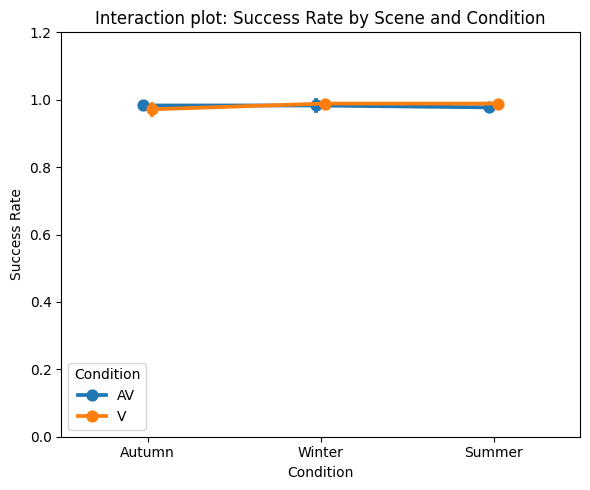

In [ ]:
# scene x condition interaction plots 

agg_scene = all_perf_data.groupby(['Participant', 'Condition', 'Scene']).agg(
    total_trials=('Success', 'count'),
    total_successes=('Success', 'sum'),
    mean_attempts=('Attempts', 'mean')
).reset_index()

scene_order = ['Autumn', 'Winter', 'Summer']
palette = {'AV':'#1f77b4', 'V': '#ff7f0e'}
agg_scene['success_rate'] = agg_scene['total_successes'] / agg_scene['total_trials']



plt.figure(figsize=(6,5))
sns.pointplot( data=agg_scene, x='Scene', y='success_rate', hue='Condition', palette=palette, errorbar=('ci', 68), dodge=True, order=scene_order)

plt.title('Interaction plot: Success Rate by Scene and Condition')
plt.ylim(0,1.2)
plt.ylabel('Success Rate')
plt.xlabel('Condition')
plt.tight_layout()
plt.show()


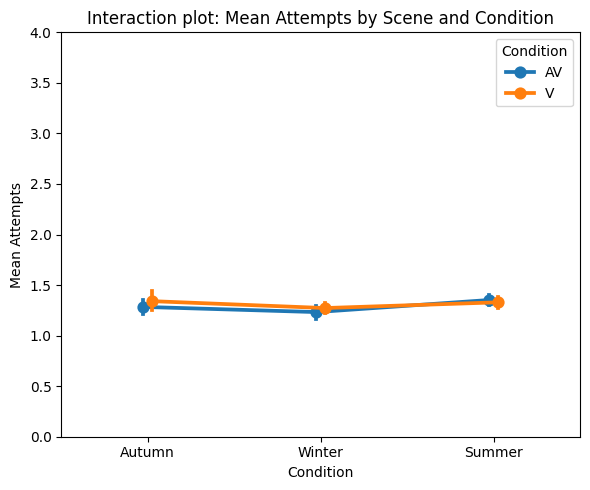

In [193]:
plt.figure(figsize=(6,5))
sns.pointplot( data=agg_scene, x='Scene', y='mean_attempts', hue='Condition', palette=palette, errorbar=('ci', 68), dodge=True, order=scene_order)

plt.title('Interaction plot: Mean Attempts by Scene and Condition')
plt.ylim(0,4)
plt.ylabel('Mean Attempts')
plt.xlabel('Condition')
plt.tight_layout()
plt.show()

### Correlation testing between GEQ and BCI Performance 

- merging the datasets for GEQ and performance on participant id 
- correlate performance (success rate, average attempts) with experience (core-module, post-module)

In [194]:
geq = pd.read_csv(r'C:\Users\alisa\Desktop\pythonMNE_testing\processed_qual_data\allGEQ.csv')


# filtering only the core module 

core_geq = geq[geq['Module'] == 'Core'].copy()

core_geq.columns = core_geq.columns.astype(str)


# Components for analysis for the Core module of the GEQ
components = {
    'Competence':['2', '10', '15', '17', '21'],
    'Immersion': ['3', '12', '18', '19', '27', '30'],
    'Flow': ['5', '13', '25', '28', '31'],
    'Tension': ['22', '24', '29'],
    'Challenge': ['11', '23', '26', '32', '33'],
    'Negative_affect': ['7', '8', '9', '16'],
    'Positive_affect': ['1', '4', '6', '14', '20']
}

# calculating mean value for each of the components in the core module
for comp, ques in components.items():
    core_geq[comp] = core_geq[ques].astype(float).mean(axis=1) # axis=0 --> rows, axis=1 --> columns


core_components = core_geq[['Q_num', 'Condition'] + list(components.keys())]

#core_components[core_components['Condition']=='AV']


post_geq = geq[geq['Module'] == 'PostGame'].copy()
post_geq.columns = post_geq.columns.astype(str)

# Components for analysis for the Post-game module of the GEQ
post_components = {
    'Positive_Experience': ['1', '5', '7', '8', '12', '16'],
    'Negative_Experience': ['2', '4', '6', '11', '14', '15'],
    'Tiredness': ['10', '13'],
    'Returning_to_Reality': ['3', '9', '17']
}

# calculating mean value for each of the components in the core module
for comp, ques in post_components.items():
    post_geq[comp] = post_geq[ques].astype(float).mean(axis=1) # axis=0 --> rows, axis=1 --> columns


post_components = post_geq[['Q_num', 'Condition'] + list(post_components.keys())]

#post_components[post_components['Condition']=='AV']

In [195]:
from scipy.stats import spearmanr

bci_av = agg[agg['Condition'] == 'AV'].copy()
geq_core_av = core_components[core_components['Condition'] == 'AV'].copy()
geq_post_av = post_components[post_components['Condition'] == 'AV'].copy()

merged_av_core = pd.merge(bci_av, geq_core_av, left_on='Participant', right_on='Q_num')
merged_av_post = pd.merge(bci_av, geq_post_av, left_on='Participant', right_on='Q_num')


bci_v = agg[agg['Condition'] == 'V'].copy()
geq_core_v = core_components[core_components['Condition'] == 'V'].copy()
geq_post_v = post_components[post_components['Condition'] == 'V'].copy()

merged_v_core = pd.merge(bci_v, geq_core_v, left_on='Participant', right_on='Q_num')
merged_v_post = pd.merge(bci_v, geq_post_v, left_on='Participant', right_on='Q_num')


# function to compute spearman correlation 

def spearman_corr(df, components):
    results = []


    for comp in components: 
        corr_succ, p_succ = spearmanr(df['success_rate'], df[comp])
        corr_attempts, p_attempts = spearmanr(df['mean_attempts'], df[comp])

        results.append({
            'GEQ Component' : comp,
            'Success rate rho' : corr_succ,
            'Success rate p' : p_succ,
            'Mean Attempts rho' : corr_attempts,
            'Mean Attempts p' : p_attempts
        })
    
    return pd.DataFrame(results)

core_vars = list(components.keys())
post_vars = list(post_components.keys())[2:] # exclude the Q_num and Condition 

cor_av_core = spearman_corr(merged_av_core, core_vars)
cor_v_core = spearman_corr(merged_v_core, core_vars)
cor_av_post = spearman_corr(merged_av_post, post_vars)
cor_v_post = spearman_corr(merged_v_post, post_vars)

print('Core GEQ Correlations for AV:\n')
print(cor_av_core)
print('\nCore GEQ Correlations for V:\n')
print(cor_v_core)



Core GEQ Correlations for AV:

     GEQ Component  Success rate rho  Success rate p  Mean Attempts rho  \
0       Competence          0.251194        0.259478          -0.246071   
1        Immersion         -0.106608        0.636786           0.206079   
2             Flow          0.329092        0.134785           0.016974   
3          Tension         -0.153233        0.495990           0.288843   
4        Challenge         -0.282987        0.201912           0.404627   
5  Negative_affect          0.106762        0.636296           0.167924   
6  Positive_affect          0.072886        0.747197          -0.015814   

   Mean Attempts p  
0         0.269642  
1         0.357517  
2         0.940235  
3         0.192333  
4         0.061779  
5         0.455073  
6         0.944313  

Core GEQ Correlations for V:

     GEQ Component  Success rate rho  Success rate p  Mean Attempts rho  \
0       Competence          0.058184        0.797028          -0.130112   
1        Immersion 

In [196]:
print('Post GEQ Correlations for AV:\n')
print(cor_av_post)
print('\nPost GEQ Correlations for V:\n')
print(cor_v_post)

Post GEQ Correlations for AV:

          GEQ Component  Success rate rho  Success rate p  Mean Attempts rho  \
0   Positive_Experience         -0.109027        0.629112           0.248788   
1   Negative_Experience         -0.531340        0.010937           0.204127   
2             Tiredness          0.295634        0.181616           0.333078   
3  Returning_to_Reality         -0.091741        0.684709           0.132717   

   Mean Attempts p  
0         0.264221  
1         0.362190  
2         0.129845  
3         0.556010  

Post GEQ Correlations for V:

          GEQ Component  Success rate rho  Success rate p  Mean Attempts rho  \
0   Positive_Experience         -0.257729        0.246870           0.459715   
1   Negative_Experience         -0.130678        0.562149           0.156797   
2             Tiredness         -0.117943        0.601156           0.193086   
3  Returning_to_Reality         -0.199429        0.373579           0.418865   

   Mean Attempts p  
0         

In [197]:
def interpret_corr(rho, p):
    abs_rho =abs(rho)

    if abs_rho < 0.1:
        strength = 'negligible'
    elif abs_rho < 0.3:
        strength = 'weak'
    elif abs_rho < 0.5:
        strength = 'moderate'
    else: 
        strength = 'strong'
    
    signif = "significant" if p < 0.05 else "not significant"
    direction = 'positive' if rho > 0 else "negative"

    return f'{strength} {direction} correlation {signif}'


cor_av_core['Success rate interpretation'] = cor_av_core.apply(lambda row: interpret_corr(row['Success rate rho'], row['Success rate p']), axis=1)
cor_v_core['Success rate interpretation'] = cor_v_core.apply(lambda row: interpret_corr(row['Success rate rho'], row['Success rate p']), axis=1)
cor_av_post['Success rate interpretation'] = cor_av_post.apply(lambda row: interpret_corr(row['Success rate rho'], row['Success rate p']), axis=1)
cor_v_post['Success rate interpretation'] = cor_v_post.apply(lambda row: interpret_corr(row['Success rate rho'], row['Success rate p']), axis=1)


cor_av_core['Mean Attempts interpretation'] = cor_av_core.apply(lambda row: interpret_corr(row['Mean Attempts rho'], row['Mean Attempts p']), axis=1)
cor_v_core['Mean Attempts interpretation'] = cor_v_core.apply(lambda row: interpret_corr(row['Mean Attempts rho'], row['Mean Attempts p']), axis=1)
cor_av_post['Mean Attempts interpretation'] = cor_av_post.apply(lambda row: interpret_corr(row['Mean Attempts rho'], row['Mean Attempts p']), axis=1)
cor_v_post['Mean Attempts interpretation'] = cor_v_post.apply(lambda row: interpret_corr(row['Mean Attempts rho'], row['Mean Attempts p']), axis=1)


In [198]:
cor_av_core

,GEQ Component,Success rate rho,Success rate p,Mean Attempts rho,Mean Attempts p,Success rate interpretation,Mean Attempts interpretation
0,Competence,0.251194,0.259478,-0.246071,0.269642,weak positive correlation not significant,weak negative correlation not significant
1,Immersion,-0.106608,0.636786,0.206079,0.357517,weak negative correlation not significant,weak positive correlation not significant
2,Flow,0.329092,0.134785,0.016974,0.940235,moderate positive correlation not significant,negligible positive correlation not significant
3,Tension,-0.153233,0.495990,0.288843,0.192333,weak negative correlation not significant,weak positive correlation not significant
4,Challenge,-0.282987,0.201912,0.404627,0.061779,weak negative correlation not significant,moderate positive correlation not significant
5,Negative_affect,0.106762,0.636296,0.167924,0.455073,weak positive correlation not significant,weak positive correlation not significant
6,Positive_affect,0.072886,0.747197,-0.015814,0.944313,negligible positive correlation not significant,negligible negative correlation not significant


In [199]:
cor_v_core

,GEQ Component,Success rate rho,Success rate p,Mean Attempts rho,Mean Attempts p,Success rate interpretation,Mean Attempts interpretation
0,Competence,0.058184,0.797028,-0.130112,0.563861,negligible positive correlation not significant,weak negative correlation not significant
1,Immersion,-0.440815,0.040030,0.425031,0.048626,moderate negative correlation significant,moderate positive correlation significant
2,Flow,-0.319739,0.146901,0.375143,0.085370,moderate negative correlation not significant,moderate positive correlation not significant
3,Tension,-0.215337,0.335840,0.200565,0.370807,weak negative correlation not significant,weak positive correlation not significant
4,Challenge,-0.219411,0.326552,0.681649,0.000477,weak negative correlation not significant,strong positive correlation significant
5,Negative_affect,0.102266,0.650650,-0.028707,0.899089,weak positive correlation not significant,negligible negative correlation not significant
6,Positive_affect,-0.189543,0.398202,-0.014405,0.949268,weak negative correlation not significant,negligible negative correlation not significant


In [200]:
cor_av_post

,GEQ Component,Success rate rho,Success rate p,Mean Attempts rho,Mean Attempts p,Success rate interpretation,Mean Attempts interpretation
0,Positive_Experience,-0.109027,0.629112,0.248788,0.264221,weak negative correlation not significant,weak positive correlation not significant
1,Negative_Experience,-0.531340,0.010937,0.204127,0.362190,strong negative correlation significant,weak positive correlation not significant
2,Tiredness,0.295634,0.181616,0.333078,0.129845,weak positive correlation not significant,moderate positive correlation not significant
3,Returning_to_Reality,-0.091741,0.684709,0.132717,0.556010,negligible negative correlation not significant,weak positive correlation not significant


In [201]:
cor_v_post

,GEQ Component,Success rate rho,Success rate p,Mean Attempts rho,Mean Attempts p,Success rate interpretation,Mean Attempts interpretation
0,Positive_Experience,-0.257729,0.246870,0.459715,0.031354,weak negative correlation not significant,moderate positive correlation significant
1,Negative_Experience,-0.130678,0.562149,0.156797,0.485900,weak negative correlation not significant,weak positive correlation not significant
2,Tiredness,-0.117943,0.601156,0.193086,0.389276,weak negative correlation not significant,weak positive correlation not significant
3,Returning_to_Reality,-0.199429,0.373579,0.418865,0.052347,weak negative correlation not significant,moderate positive correlation not significant


In [202]:
print(cor_av_core)
print(cor_v_core)
print(cor_av_post)
print(cor_v_post)


     GEQ Component  Success rate rho  Success rate p  Mean Attempts rho  \
0       Competence          0.251194        0.259478          -0.246071   
1        Immersion         -0.106608        0.636786           0.206079   
2             Flow          0.329092        0.134785           0.016974   
3          Tension         -0.153233        0.495990           0.288843   
4        Challenge         -0.282987        0.201912           0.404627   
5  Negative_affect          0.106762        0.636296           0.167924   
6  Positive_affect          0.072886        0.747197          -0.015814   

   Mean Attempts p                      Success rate interpretation  \
0         0.269642        weak positive correlation not significant   
1         0.357517        weak negative correlation not significant   
2         0.940235    moderate positive correlation not significant   
3         0.192333        weak negative correlation not significant   
4         0.061779        weak negative corr

Core GEQ

- moderate negative correlation between success rate and Immersion in V core (rho= -0.44, p = 0.04, p< 0.05)
    - particiapnts that felt more immersed in the V version of the game had lower performance 
- moderate positive correlation between attempts and Immersion in V core (rho = 0.42, p=0.049)
    - further substantiates that participants that felt more immersed in the V version had lower performance (hence more average attempts)

- strong positive correlation between mean attempts and Challenge in V core (rho=0.68, p<0.001, p=0.00048)
    - participants that perceived greater challenge in the V version of the game required more attempts 


Post GEQ 
- strong negative correlation between success rate and Negative Experience in AV post (rho = -0.531340, p = 0.010937)
    - as the participants perceived more negative experiences in the game, their performance went down 

- moderate positive correlation between average attempts and Positive experience in V post (rho = 0.459715, p = 0.031354)
    - participants that required more average attempts reported higher positive experience in the V game. This correlation was also positive in the AV version, however it was insignificant and small (rho = 0.248788, p = 0.264221)
    - perhaps particiapnts that fell into this category are evidence of the challenge-reward hypothesis, where a task is perceived as more rewarding due to the perceived higher challenge. 
    - considering the verbal feedback regarding the negative auditory feedback in the game, perhaps thsi correlation is only present in the V post GEQ because the silent atmosphere prevented the participants from getting overly frustrated with the negative sound feedback. Instead, the silence may have allowed their greater number of attempts to feel more rewarding, rather than punishing (?) 



for other subjective components, the correlation to performance is weak and insignificant or absent. Several moderate correlations were observed but did not reach statistical significance, likely due to limited sample size.



#### AV-V difference scores correlation 
- for each participant we are computing: 
    - delta success rate = success rate AV - success rate V 
    - delta attempts = avg attempts AV - avg attempts V 
    - delta GEQ = GEQ AV - GEQ V  (separate core and post)
- then we will correlate the BCI changes with the subjective changes. this will tell us whether the changes in subjective experience following the addition of sound predict changes in BCI performance 

In [ ]:
bci_wide = agg.pivot(index='Participant', columns='Condition', values=['success_rate', 'mean_attempts']).reset_index()
bci_wide.columns = ['Participant', 'mean_attempts_AV', 'mean_attempts_V', 'success_rate_AV', 'success_rate_V']

bci_wide['success_rate_diff'] = bci_wide['success_rate_AV'] - bci_wide['success_rate_V']
bci_wide['mean_attempts_diff'] = bci_wide['mean_attempts_AV'] - bci_wide['mean_attempts_V']

core_wide = core_components.pivot(index='Q_num', columns='Condition')
core_wide.columns = [f"{var}_{cond}" for var, cond in core_wide.columns]
core_wide.reset_index(inplace=True)

for comp in components.keys():
    core_wide[f'{comp}_diff'] = core_wide[f'{comp}_AV'] - core_wide[f'{comp}_V']

merged_diff = pd.merge(bci_wide, core_wide, left_on='Participant', right_on='Q_num')

#Computing correlations
results = []
for comp in components.keys():
    rho_sr, p_sr = spearmanr(merged_diff['success_rate_diff'], merged_diff[f'{comp}_diff'])
    rho_ma, p_ma = spearmanr(merged_diff['mean_attempts_diff'], merged_diff[f'{comp}_diff'])
    results.append({
        'GEQ Component': comp,
        'Success Rate Diff rho': rho_sr,
        'Success Rate Diff p': p_sr,
        'Mean Attempts Diff rho': rho_ma,
        'Mean Attempts Diff p': p_ma
    })

diff_results = pd.DataFrame(results)
diff_results

,GEQ Component,Success Rate Diff rho,Success Rate Diff p,Mean Attempts Diff rho,Mean Attempts Diff p
0,Competence,-0.255768,0.250610,0.254986,0.252112
1,Immersion,0.557367,0.007041,-0.618554,0.002150
2,Flow,0.216454,0.333277,-0.102971,0.648390
3,Tension,0.330778,0.132679,-0.382825,0.078663
4,Challenge,0.226086,0.311673,-0.254095,0.253831
5,Negative_affect,0.136891,0.543540,0.027253,0.904177
6,Positive_affect,0.228859,0.305616,-0.169282,0.451379


- greater perception of Immersion has a significant positive correlation with Success rate and a significant negative correlation with mean attempts, which suggests that participants that felt more immersed in the game performed better. 
- participants that felt greater immersion following the addition of sound showed greater performance in BCI accuracy and required fewer attempts. 
- subjective experience of competence, flow, tension, challenge, negative affect and positive affect were not correlated with changes in BCI performance. this could suggest that the addition of audio may enhance the feeling of immersion, which, for some participants that greatly experience this difference, enhances their BCI performance. 

In [204]:
post_wide = post_components.pivot(index='Q_num', columns='Condition')
post_wide.columns = [f"{var}_{cond}" for var, cond in post_wide.columns]
post_wide.reset_index(inplace=True)

post_vars = ['Positive_Experience', 'Negative_Experience', 'Tiredness', 'Returning_to_Reality']

for comp in post_vars:
    post_wide[f'{comp}_diff'] = post_wide[f'{comp}_AV'] - post_wide[f'{comp}_V']

merged_diff_post = pd.merge(bci_wide, post_wide, left_on='Participant', right_on='Q_num')

results_post = []
for comp in post_vars:
    rho_sr, p_sr = spearmanr(merged_diff_post['success_rate_diff'], merged_diff_post[f'{comp}_diff'])
    rho_ma, p_ma = spearmanr(merged_diff_post['mean_attempts_diff'], merged_diff_post[f'{comp}_diff'])
    results_post.append({
        'GEQ Component': comp,
        'Success Rate Diff rho': rho_sr,
        'Success Rate Diff p': p_sr,
        'Mean Attempts Diff rho': rho_ma,
        'Mean Attempts Diff p': p_ma
    })

diff_results_post = pd.DataFrame(results_post)
print(diff_results_post)

          GEQ Component  Success Rate Diff rho  Success Rate Diff p  \
0   Positive_Experience               0.031108             0.890696   
1   Negative_Experience               0.206101             0.357467   
2             Tiredness              -0.053902             0.811695   
3  Returning_to_Reality               0.187399             0.403658   

   Mean Attempts Diff rho  Mean Attempts Diff p  
0                0.213135              0.340924  
1               -0.417208              0.053384  
2               -0.075933              0.736982  
3               -0.293412              0.185076  


- no significant correlation between changes in subjective experience and changes in BCI performance for the post-game module

from chat: 

- The strongest relationship between subjective and objective effects of audio feedback was found for Immersion (Core GEQ).
- Post-Game GEQ showed no strong associations.
- Overall, subjective immersion improvements appear to be the most robust predictor of BCI performance improvement when adding audio feedback.
- "Taken together, the findings suggest that immersion-related experience during gameplay may play a more critical role in modulating BCI performance than retrospective positive or negative affect ratings collected post-task."

### Responder analysis - V condition 
- split data into 'good' and 'bad' performers 
- compare subjective GEQ scores between groups 

In [205]:
from scipy.stats import mannwhitneyu

bci_v = agg[agg['Condition'] == 'V'].copy()

median_sr = bci_v['success_rate'].median()

bci_v['Group'] = ['High Performer' if sr >= median_sr else 'Low Performer' for sr in bci_v['success_rate']]

geq_v_core = core_components[core_components['Condition'] == 'V'].copy()
merged_responder = pd.merge(bci_v, geq_v_core, left_on='Participant', right_on='Q_num')

group_results = []
for comp in components.keys():
    high = merged_responder[merged_responder['Group'] == 'High Performer'][comp]
    low = merged_responder[merged_responder['Group'] == 'Low Performer'][comp]
    stat, p = mannwhitneyu(high, low)
    group_results.append({
        'GEQ Component': comp,
        'High mean': high.mean(),
        'Low mean': low.mean(),
        'Difference': high.mean() - low.mean(),
        'p': p
    })

responder_df = pd.DataFrame(group_results)
responder_df

,GEQ Component,High mean,Low mean,Difference,p
0,Competence,2.882353,2.760000,0.122353,0.752497
1,Immersion,2.509804,3.333333,-0.823529,0.070672
2,Flow,2.270588,2.760000,-0.489412,0.207555
3,Tension,0.254902,0.400000,-0.145098,0.393122
4,Challenge,0.905882,1.480000,-0.574118,0.385283
5,Negative_affect,0.558824,0.500000,0.058824,0.631475
6,Positive_affect,2.894118,3.360000,-0.465882,0.427022


- for each of the components, the difference in subjective experience between the high and low performers is not significant. 
- however, there are some interesting differences between the high and low performers. 
- those that performed more poorly had higher immersion & those that performed more poorly had a greater positive affect --> this is in line with the previous analysis that confirmed that there was a positive correlation between positive affect and number of attempts. These differences in positive affect and immersion are not statitically significant, but they are in line with previous findings. Particularly for postive affect the difference is highly likely due to chance (p=0.43). This could also be a de-coupling between subjective experience and objective performance, where immersion or perceived engagement does not translate into performance. 

In [206]:
bci_av = agg[agg['Condition'] == 'AV'].copy()

median_sr = bci_av['success_rate'].median()

bci_av['Group'] = ['High Performer' if sr >= median_sr else 'Low Performer' for sr in bci_av['success_rate']]

geq_v_core = core_components[core_components['Condition'] == 'AV'].copy()
merged_responder = pd.merge(bci_av, geq_v_core, left_on='Participant', right_on='Q_num')

group_results = []
for comp in components.keys():
    high = merged_responder[merged_responder['Group'] == 'High Performer'][comp]
    low = merged_responder[merged_responder['Group'] == 'Low Performer'][comp]
    stat, p = mannwhitneyu(high, low)
    group_results.append({ 
        'GEQ Component': comp,
        'High mean': high.mean(),
        'Low mean': low.mean(),
        'Difference': high.mean() - low.mean(),
        'p': p
    })

responder_df = pd.DataFrame(group_results)
responder_df

,GEQ Component,High mean,Low mean,Difference,p
0,Competence,3.162500,2.766667,0.395833,0.206748
1,Immersion,2.833333,3.027778,-0.194444,0.602107
2,Flow,2.962500,2.466667,0.495833,0.085517
3,Tension,0.166667,0.444444,-0.277778,0.344819
4,Challenge,0.937500,1.433333,-0.495833,0.169820
5,Negative_affect,0.515625,0.416667,0.098958,0.644247
6,Positive_affect,3.300000,3.366667,-0.066667,0.765034


- for AV also no significant difference between high and low performers in their perceived GEQ components. However, the Flow component has a trend-level difference between high and low performers. Participants that performed more highly in the AV game experienced greater flow than those that performed poorly. 